In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scienceplots
from tensorflow import keras
from utils.helper import (
    folder_to_sequence,
    MinMaxScaler_AE,
)
import sys

sys.path.append("../")
from train_model import PARAMETERS

plt.style.use(["science", "ieee", "notebook"])

plt.rcParams["font.size"] = 12
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["figure.figsize"] = (9, 4)

In [2]:
DEFAULT_WS = PARAMETERS["window_size"]
print(DEFAULT_WS)

20


In [3]:
Xnormal, Ynormal = folder_to_sequence("VIDRO-B3", DEFAULT_WS)
Xpainco, Ypainco = folder_to_sequence("PAINCO", DEFAULT_WS)

Xscaler = MinMaxScaler_AE()
Yscaler = MinMaxScaler_AE()

Xscaler.fit(Xnormal)
Yscaler.fit(Ynormal)

Xnormal = Xscaler.transform(Xnormal)
Xpainco = Xscaler.transform(Xpainco)

Ynormal = Yscaler.transform(Ynormal)
Ypainco = Yscaler.transform(Ypainco)

seq2seq = keras.models.load_model("../models/best_model.keras")

  0%|          | 0/27 [00:00<?, ?it/s]

100%|██████████| 13/13 [00:00<00:00, 42.55it/s]


In [5]:
from joblib import Parallel, delayed


# Function to perform a single stochastic forward pass with dropout
def stochastic_forward_pass(model, X_test):
    return model(X_test, training=True).numpy()


# Function to perform MC Dropout with parallel computation
def mc_dropout_predict_parallel(model, X_test, n_forward_passes=100, n_jobs=-1):
    # Use joblib to run parallel forward passes
    predictions = Parallel(n_jobs=n_jobs)(
        delayed(stochastic_forward_pass)(model, X_test) for _ in range(n_forward_passes)
    )

    # Convert predictions list into numpy array
    predictions = np.array(
        predictions
    )  # Shape: (n_forward_passes, n_samples, time_steps)

    # Compute mean and uncertainty (standard deviation)
    mean_prediction = np.mean(predictions, axis=0)  # Mean across forward passes
    assert mean_prediction.shape[1] == X_test.shape[1], f"Shape mismatch: {mean_prediction.shape} != {X_test.shape}"

    uncertainty = np.std(predictions, axis=0)  # Uncertainty (std dev)

    return mean_prediction, uncertainty

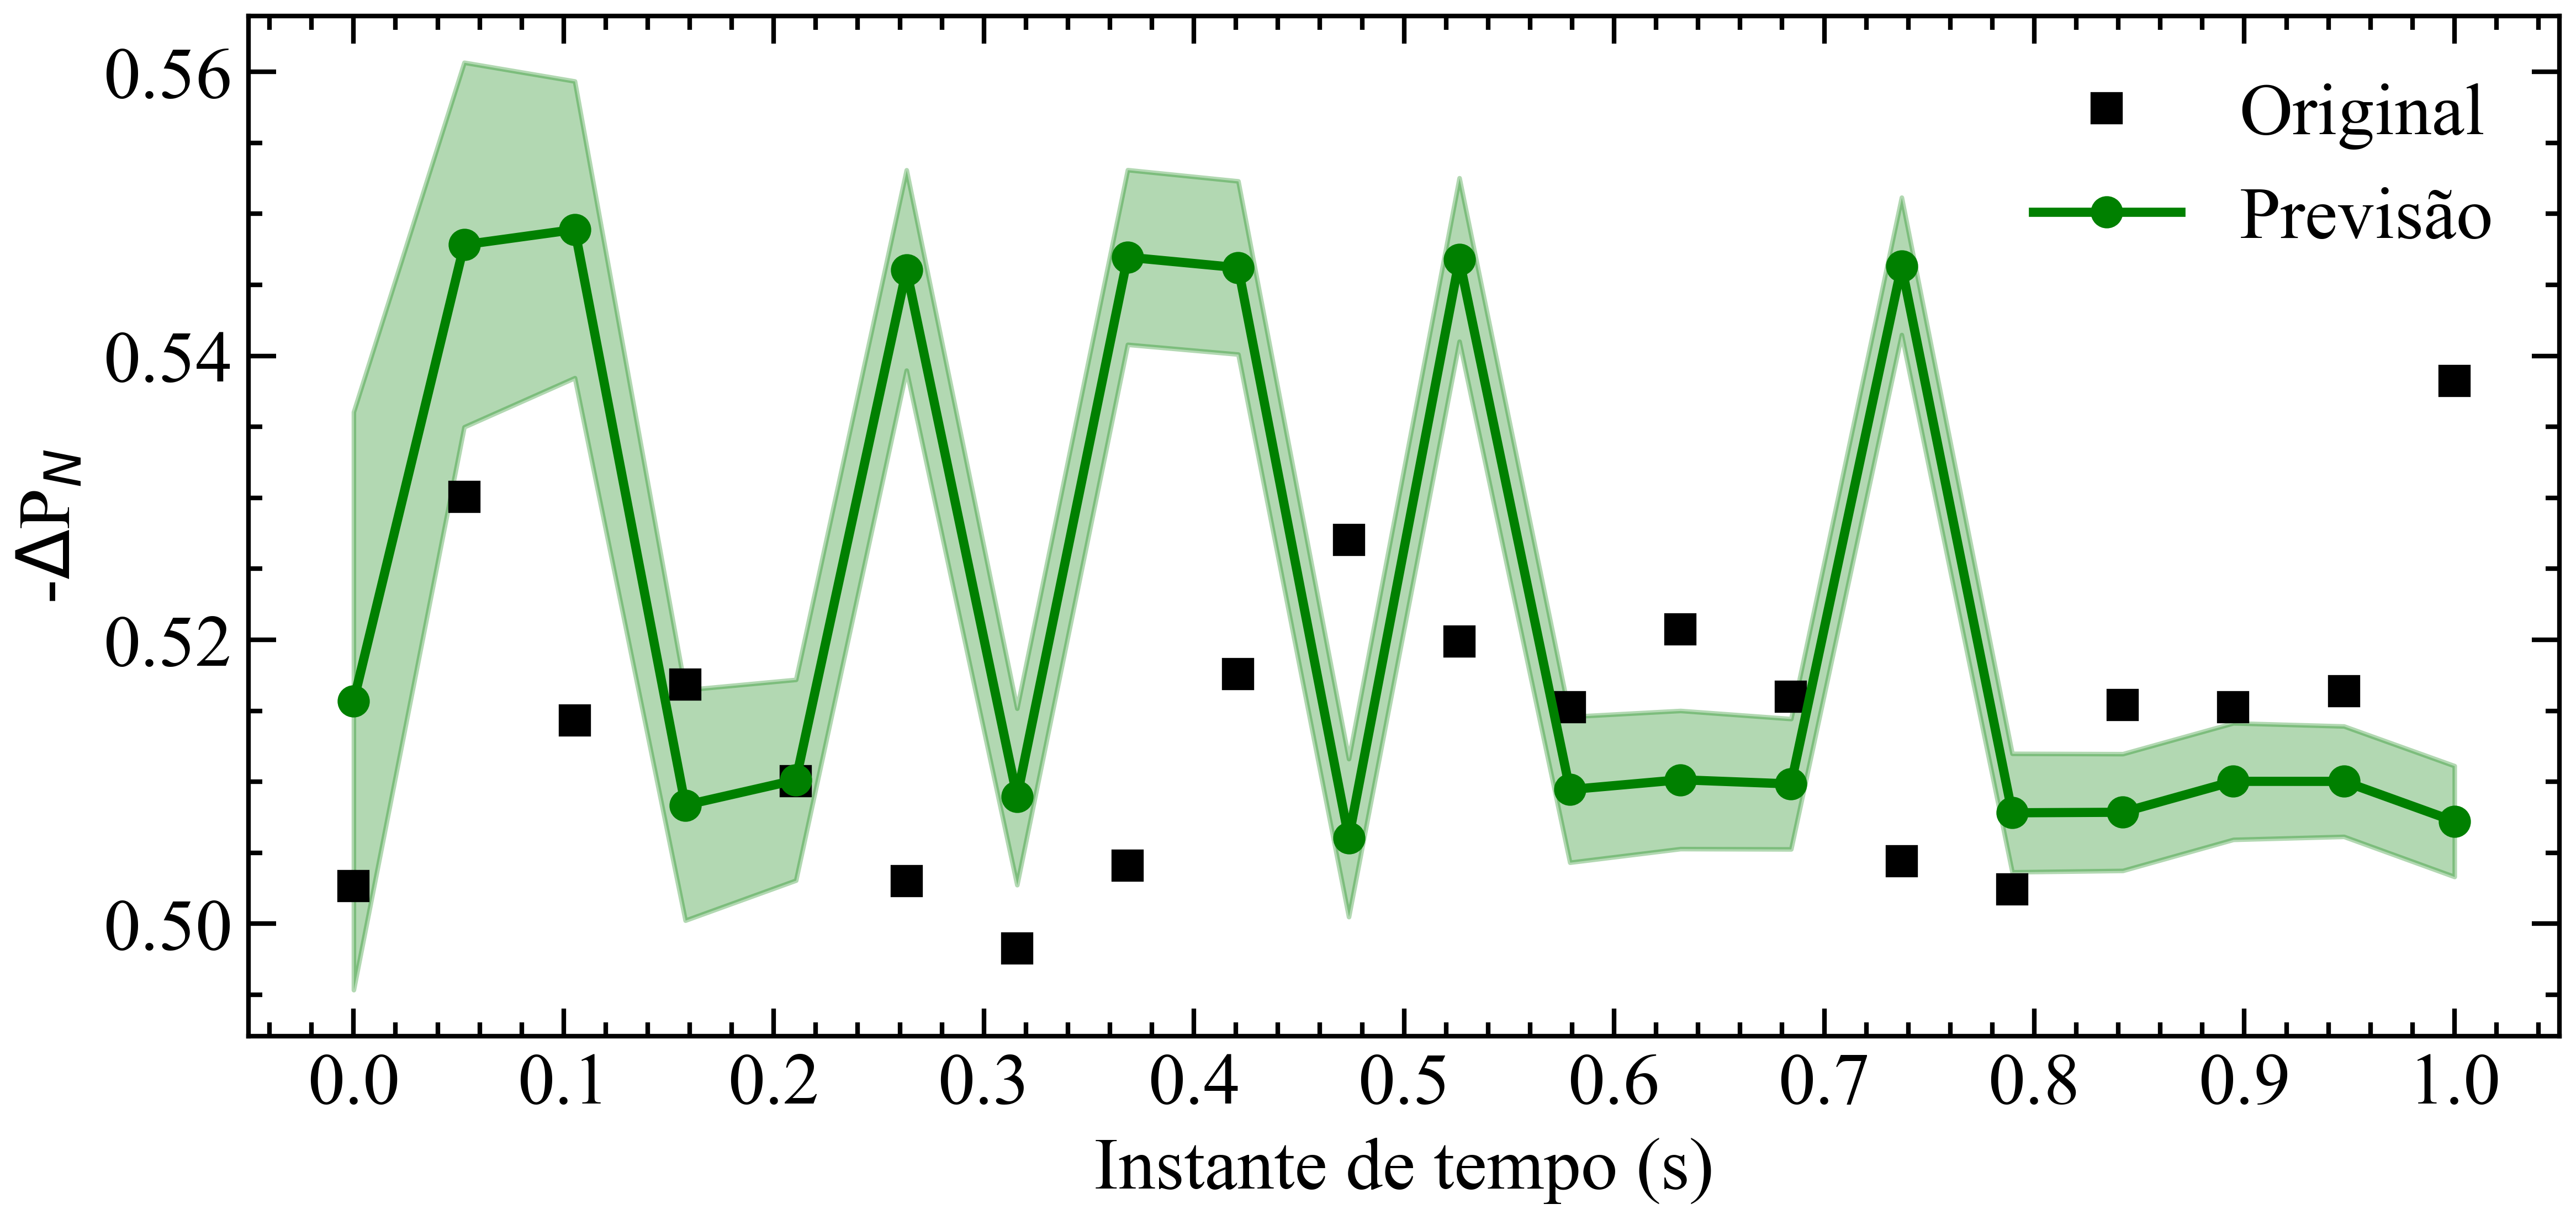

In [10]:
index: int = 7200
mean, std = mc_dropout_predict_parallel(
    seq2seq, np.expand_dims(Xnormal[index], 0), 10
)

plt.xticks(np.arange(0, 22, 2) * 1 / 20)
ymin = (mean - std).flatten()
ymax = (mean + std).flatten()

x = np.linspace(0, 20, len(Xnormal[index])) * 1 / 20

plt.plot(x, Ynormal[index], label="Original", marker='s', ls='')

plt.plot(x, mean.flatten(), label="Previsão", c="green", marker='o', ls='-')
plt.xlabel("Instante de tempo (s)")
plt.ylabel(r"-$\Delta$P$_N$")
plt.fill_between(x, ymin, ymax, alpha=0.3, color="green")
plt.legend()

plt.savefig("../images/autoencoder/normal_prediction.png", dpi=300, bbox_inches="tight");

In [6]:
Ynormal.shape

(33031, 20, 1)

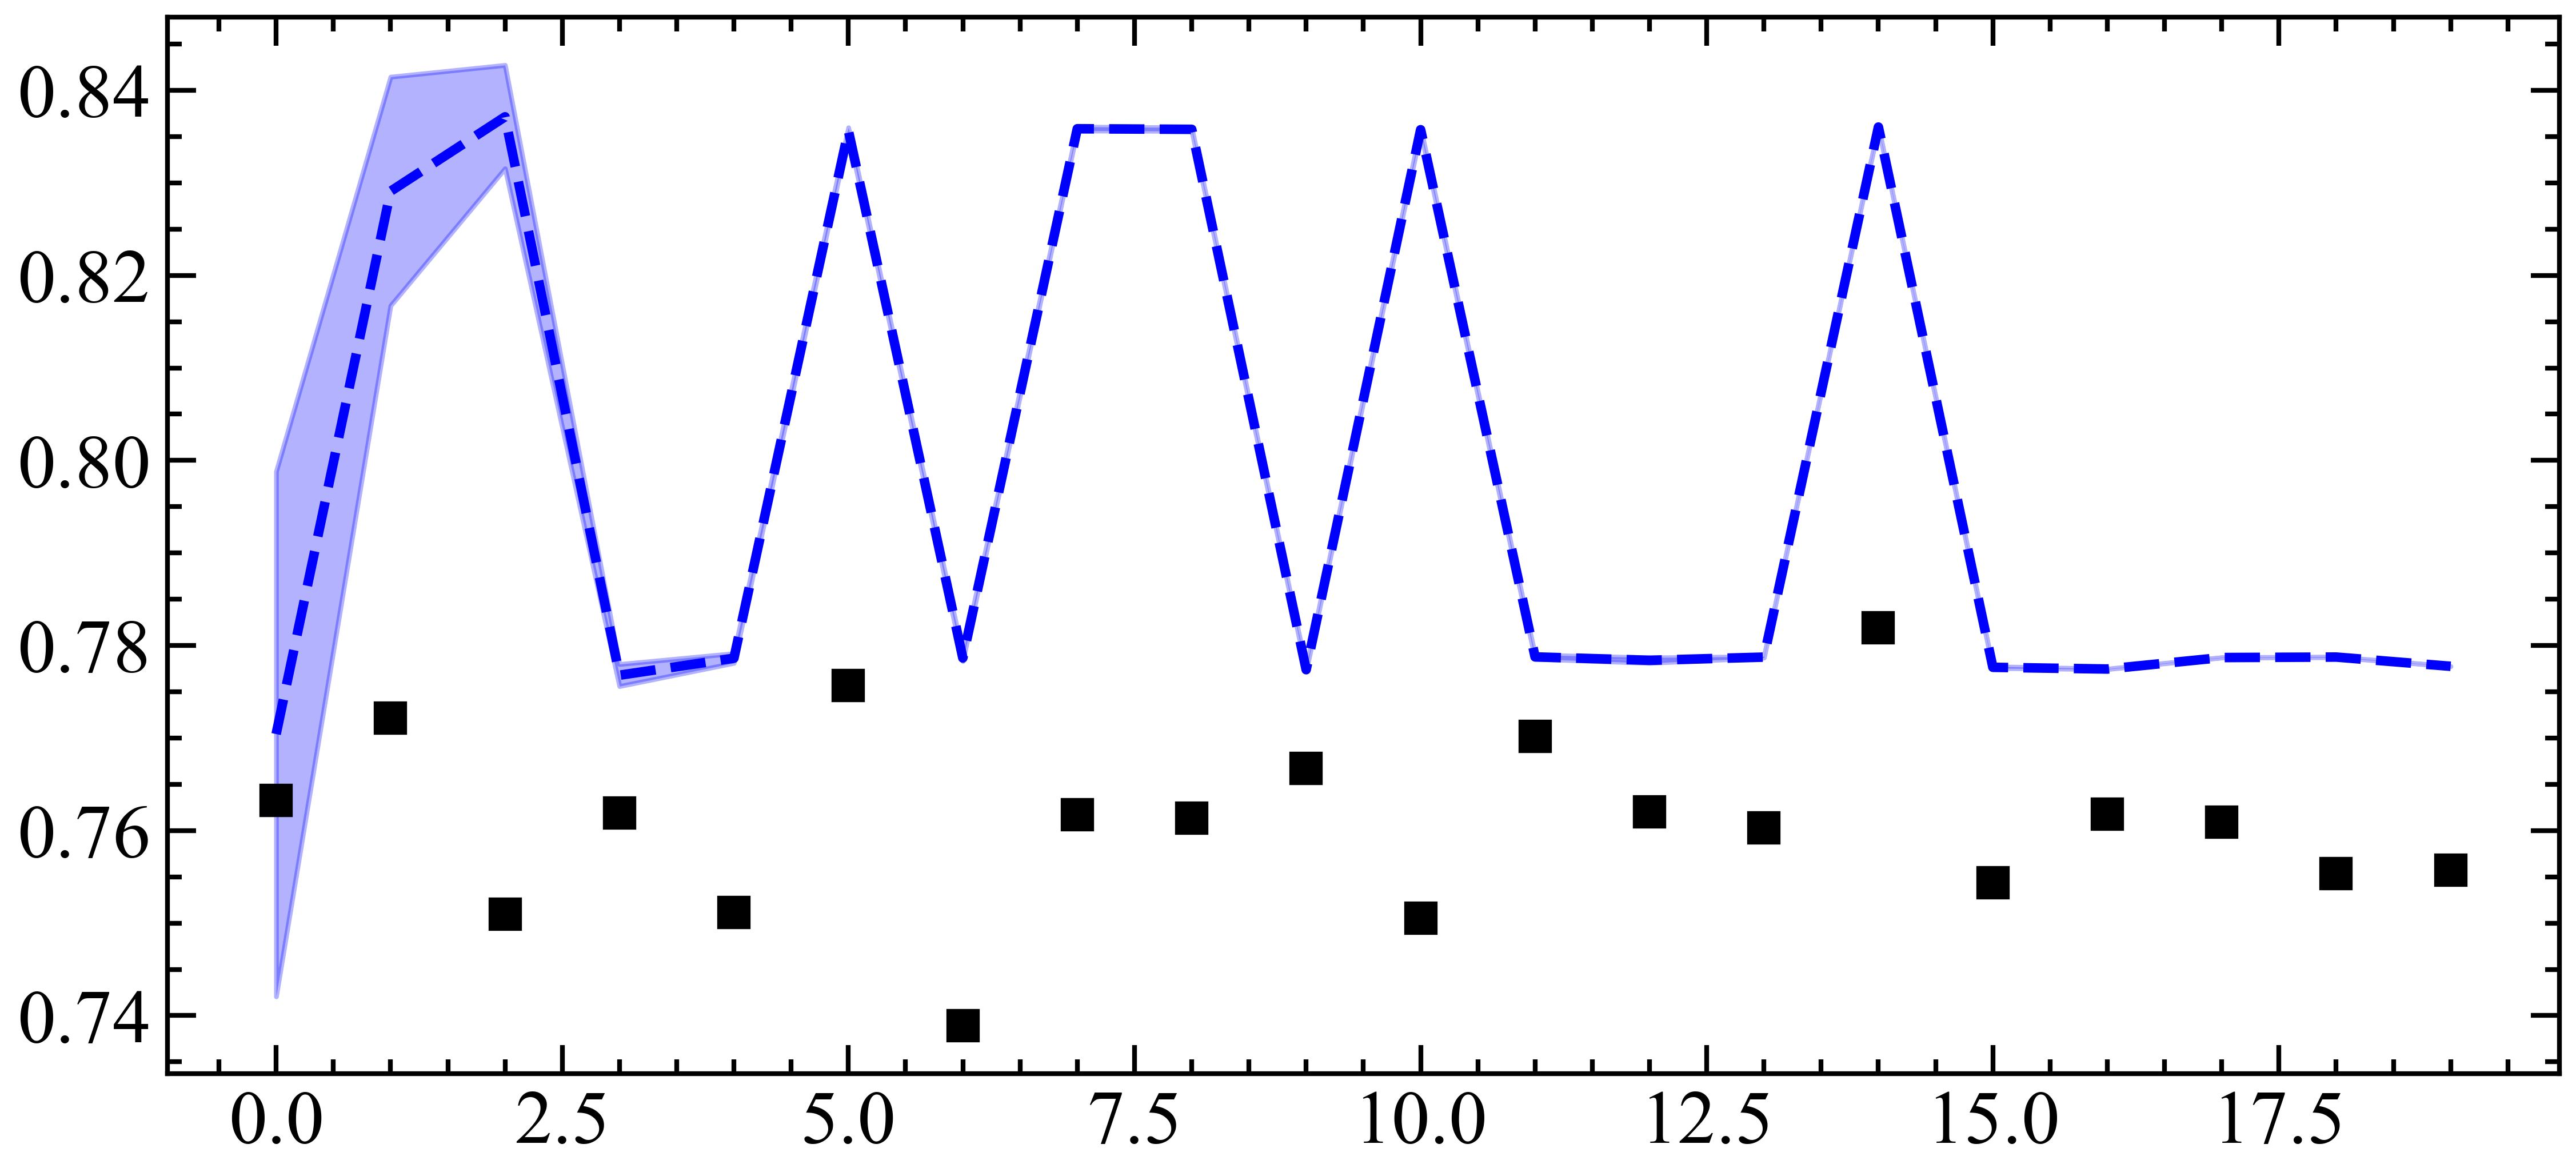

In [7]:
index: int = 1000
mean, std = mc_dropout_predict_parallel(
    seq2seq, Xpainco[index].reshape(1, DEFAULT_WS, 1), 10
)

ymin = (mean - std).flatten()
ymax = (mean + std).flatten()
x = range(DEFAULT_WS)

plt.plot(x, Ypainco[index], label="Normal", marker='s', ls='')
plt.plot(x, mean.flatten(), c='blue')
plt.fill_between(x, ymin, ymax, alpha=0.3, color="blue");